# Gradient Boosting

O algoritmo Gradient Boosting é uma técnica de aprendizado de máquina para problemas de regressão e classificação que produz um modelo de previsão a partir de uma combinação de modelos de previsão fracos, geralmente árvores de decisão.

O objetivo do algoritmo é criar uma corrente de modelos fracos, onde cada um tem como objetivo minimizar o erro do modelo anterior, por meio de uma função de perda.

Aos ajustes de cada modelo fraco é multiplicado um valor chamado de taxa de aprendizagem. Esse valor, tem como objetivo determinar o impacto de cada árvore no modelo final. Quanto menor o valor, menor a contribuição de cada árvore.

Nesta primeira parte, será construído o modelo de Gradient Boosting utilizando uma técnica de divisão de dados fixa na proporção de 70/30.

In [197]:
# Bibliotecas
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

In [166]:
# Utilizando os dados codificados
df = pd.read_csv('datasets/updated_pollution_dataset_encoded.csv')

In [167]:
# Separando o atributo alvo dos preditores
X = df.drop('Air Quality Encoded', axis=1)
y = df['Air Quality Encoded']

In [168]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [169]:
# Definindo o modelo e seus hiperparâmetros
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [170]:
# Treinando o modelo com dados de treino
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [171]:
y_pred_gb = clf.predict(X_test)
# print(y_pred_gb)

In [192]:
acuracia_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='macro')
precisao_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
print(f"Métricas \nAcurácia: {acuracia_gb:.2f} \nF1-score: {f1_gb:.2f} \nPrecisão: {precisao_gb:.2f} \nRecall: {recall_gb:.2f}")

Métricas 
Acurácia: 0.96 
F1-score: 0.94 
Precisão: 0.94 
Recall: 0.93


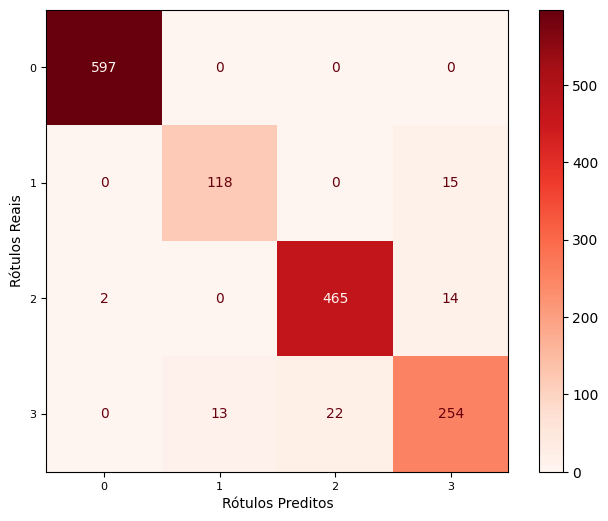

In [173]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax = ax, cmap='Reds')

ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

Sabendo que o objetivo deste modelo é aprimorar os resultados a cada passo, podemos analisar também a evolução da média de erros ao longo dos estágios da Gradient Boosting

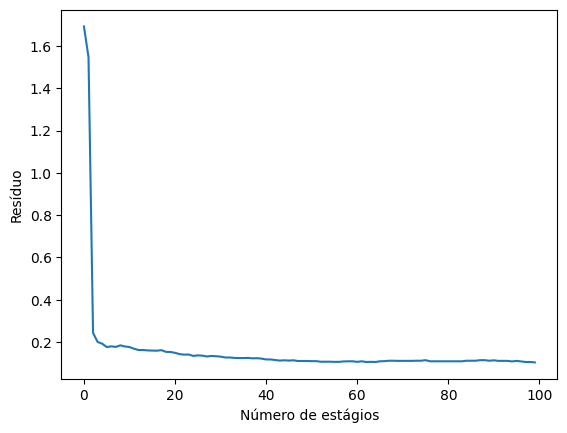

In [174]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in clf.staged_predict(X_test)]

plt.plot(errors)
plt.ylabel('Resíduo')
plt.xlabel('Número de estágios')
plt.show()

## Gradient Boosting com validação cruzada

A validação cruzada consiste em dividir o conjunto de dados em K partes (ou folds) e, a cada iteração, usa-se K-1 folds para o treino do modelo e o K restante, para o teste. Essa técnica permite que todos os dados sejam usados tanto para treino quanto para validação, buscando garantir uma validação mais robusta e menos enviesada.

In [175]:
# Definindo o número de folds utilizado
num_folds = 5

In [176]:
metricas_desejadas = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [185]:
modelo_kfold = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [186]:
# A função cross_validate realiza o treino e o teste do modelo
resultados_validacaocruzada = cross_validate(modelo_kfold, X, y, scoring=metricas_desejadas, cv=num_folds)

acuracia_kfold = resultados_validacaocruzada['test_accuracy'].mean()
precisao_kfold= resultados_validacaocruzada['test_precision_macro'].mean()
f1_kfold = resultados_validacaocruzada['test_f1_macro'].mean()
recall_kfold = resultados_validacaocruzada['test_recall_macro'].mean()
# Acessando os resultados
print(f"Acurácia: {acuracia_kfold:.2f}")
print(f"Precisão: {precisao_kfold:.2f}")
print(f"Recall: {recall_kfold:.2f}")
print(f"F1-score: {f1_kfold:.2f}")

Acurácia: 0.95
Precisão: 0.94
Recall: 0.93
F1-score: 0.93


In [187]:
y_pred_kfold = cross_val_predict(modelo_kfold, X, y, cv=num_folds)

C:\Users\proje\AppData\Local\Temp\ipykernel_16032\1357583249.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


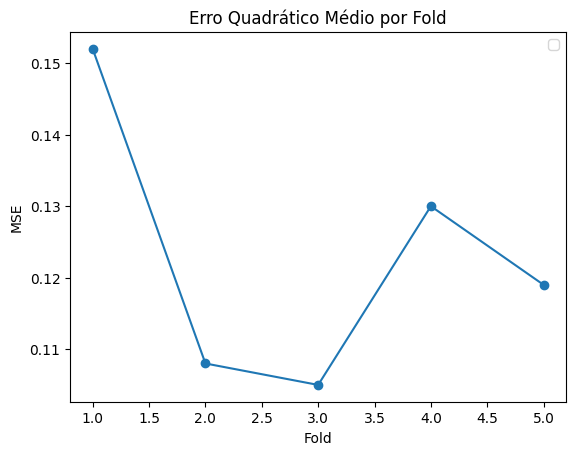

In [188]:
results = cross_validate(modelo_kfold, X, y, cv=5, scoring='neg_mean_squared_error')


mse_folds = -results['test_score']


plt.plot(range(1, 6), mse_folds, marker='o')
plt.title('Erro Quadrático Médio por Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

## Gradient Boosting com GridSearch

A técnica de GridSearchCV realiza uma busca sobre um conjunto de parâmetros predefinidos afim de evitar a arbitrariedade em um único modelo. Utilizá-la ao implementar um algoritmo de Gradient Boosting permite que tenhamos uma maior variedade de modelos para análise de sua eficiência de acordo com seus hiperparâmetros. Assim, nesta parte, faremos a implementação do GridSearch junto ao Gradient Boosting para explorarmos novos modelos e compararmos com os obtidos anteriormente.

In [193]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.05, 0.2]
 }

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 42),
                           param_grid = param_grid,
                           cv = 5,  # número de folds
                           n_jobs = -1,
                           scoring = 'f1_macro',
                           verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='f1_macro', verbose=2)

In [194]:
print("Melhores parâmetros encontrados:", grid_search.best_params_)
print(f"Melhor F1-score médio: {grid_search.best_score_:.2f}")

Melhores parâmetros encontrados: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Melhor F1-score médio: 0.92


In [183]:
# Treinando o modelo com os melhores parâmetros encontrados pelo GridSearchCV:

final_model = GradientBoostingClassifier(**grid_search.best_params_, random_state = 0)
final_model.fit(X_train, y_train)

y_final_pred = final_model.predict(X_test)

acuracia_gs = accuracy_score(y_test, y_final_pred)
precisao_gs = precision_score(y_test, y_final_pred, average = 'macro') 
recall_gs = recall_score(y_test, y_final_pred, average = 'macro')
f1_gs = f1_score(y_test, y_final_pred, average = 'macro')

print("=== Resultados de Avaliação ===")
print(f"Acurácia:  {acuracia_gs:.2f}")
print(f"Precisão:  {precisao_gs:.2f}")
print(f"Recall:    {recall_gs:.2f}")
print(f"F1-Score:  {f1_gs:.2f}")

=== Resultados de Avaliação ===
Acurácia:  0.95
Precisão:  0.93
Recall:    0.93
F1-Score:  0.93


In [198]:
os.makedirs('gradient_boosting', exist_ok = True)
joblib.dump(clf, 'gradient_boosting/gradientboosting_air_quality_standard.joblib')
joblib.dump(final_model, 'gradient_boosting/final_model_gridsearch.joblib')

['gradient_boosting/final_model_gridsearch.joblib']

## Conclusão

In [190]:
data = {
    'Modelo': ['G. Boosting Padrão', 'G. Boosting com KFold', 'G. Boosting com GridSearch'],
    'Acurácia': [acuracia_gb, acuracia_kfold, acuracia_gs],
    'Precisão': [precisao_gb, precisao_kfold, precisao_gs],
    'Recall': [recall_gb, recall_kfold, recall_gs],
    'F1-Score': [f1_gb, f1_kfold, f1_gs]
}

df_resultados = pd.DataFrame(data)

colunas_metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
df_resultados[colunas_metricas] = df_resultados[colunas_metricas].applymap(lambda x: f"{x * 100:.2f}%")


print("\nComparação de Modelos\n")
print(df_resultados.to_string(index = False))


Comparação de Modelos

                    Modelo Acurácia Precisão Recall F1-Score
        G. Boosting Padrão   95.60%   93.74% 93.32%   93.53%
     G. Boosting com KFold   95.40%   93.75% 92.87%   93.25%
G. Boosting com GridSearch   95.20%   93.13% 92.53%   92.82%


C:\Users\proje\AppData\Local\Temp\ipykernel_16032\1802027592.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_resultados[colunas_metricas] = df_resultados[colunas_metricas].applymap(lambda x: f"{x * 100:.2f}%")


Com base nos valores de métricas obtidas, é possível observar pouca variação entre os valores, mas, ainda assim, uma vantagem do Gradient Boosting padrão em métricas como f1-score e acurácia. No entanto, é importante destacar a importância dos modelos de GridSearch e validação cruzada que, apesar das métricas inferiores, cumprem seus papéis em apresentar variações do modelo proposto para enriquecer a análise da importância dos parâmetros definidos. 